# Import Library

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Preparation 

## Data Loading

In [2]:
# Direktori dataset di Kaggle
dataset_path = "/kaggle/input/vegetable-image-dataset/Vegetable Images"

# Cek jumlah kelas
classes = os.listdir(os.path.join(dataset_path, "train"))
print(f"Jumlah kelas: {len(classes)}")
print(f"Daftar kelas: {classes}")

Jumlah kelas: 15
Daftar kelas: ['Broccoli', 'Capsicum', 'Bottle_Gourd', 'Radish', 'Tomato', 'Brinjal', 'Pumpkin', 'Carrot', 'Papaya', 'Cabbage', 'Bitter_Gourd', 'Cauliflower', 'Bean', 'Cucumber', 'Potato']


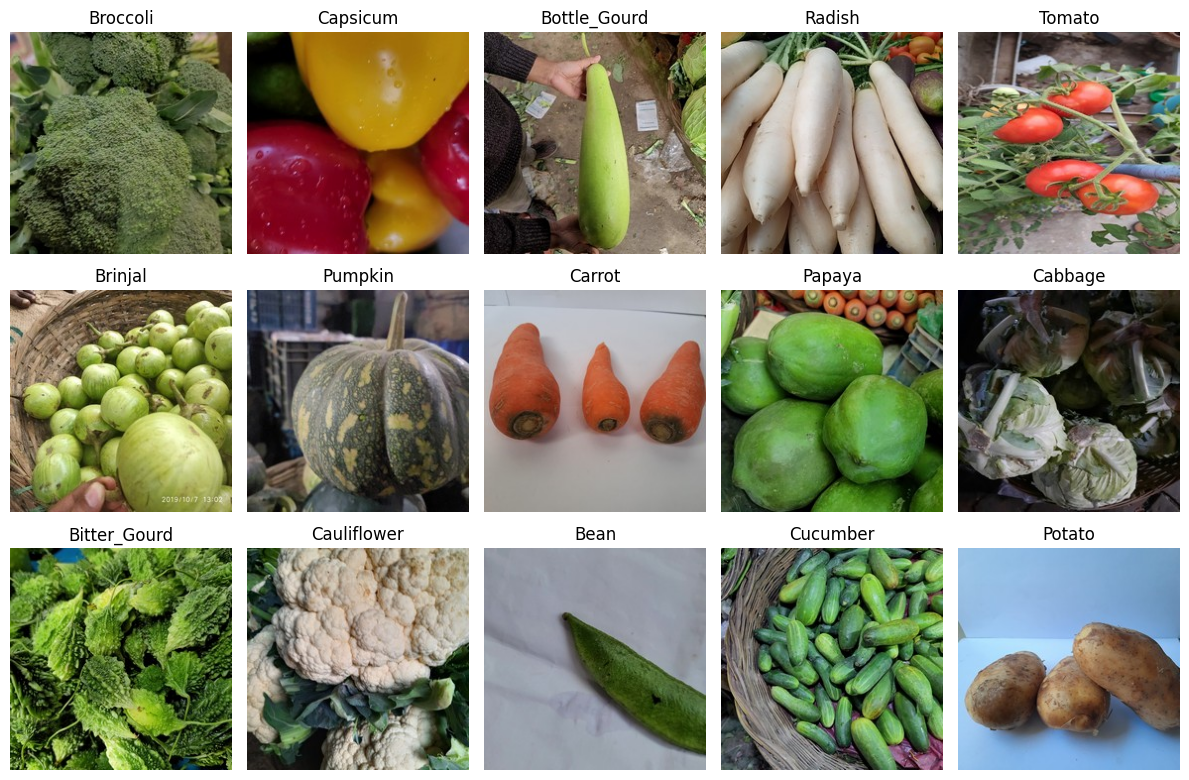

In [3]:
# Tampilkan contoh gambar dari dataset
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.flatten()

for i, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, "train", cls)
    sample_img = os.listdir(class_path)[0]
    img = plt.imread(os.path.join(class_path, sample_img))
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [4]:
# Cek apakah gambar memiliki resolusi yang tidak seragam
img_shapes = []
for cls in classes:
    class_path = os.path.join(dataset_path, "train", cls)
    sample_img = os.listdir(class_path)[0]
    img = plt.imread(os.path.join(class_path, sample_img))
    img_shapes.append(img.shape)

print("Beberapa ukuran gambar:", img_shapes[:10])  

Beberapa ukuran gambar: [(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]


Dalam **Vegetable Image Dataset** ini, ukuran gambar sudah seragam yaitu 224 x 224 pixel

## Data Split & Preprocessing

In [5]:
# Menentukan strategi split dataset terbaik
train_dir = os.path.join(dataset_path, "train")
val_dir   = os.path.join(dataset_path, "validation") 
test_dir  = os.path.join(dataset_path, "test")

# ImageDataGenerator dengan augmentasi hanya untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=50.0,
    fill_mode="nearest"
)

# Data generator untuk masing-masing set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


# Modelling

In [6]:
# Membangun model CNN 
model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3,3), activation="relu", padding="same"),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu", padding="same"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.25),
    Dense(128, activation="relu"),
    Dense(15, activation="softmax")
])

# Compile model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")

# Training model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50, 
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 258s 531ms/step - accuracy: 0.2768 - loss: 2.3100 - val_accuracy: 0.5140 - val_loss: 1.4102
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 241s 508ms/step - accuracy: 0.5418 - loss: 1.3218 - val_accuracy: 0.6730 - val_loss: 0.9910
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 239s 503ms/step - accuracy: 0.6347 - loss: 1.0828 - val_accuracy: 0.7577 - val_loss: 0.7693
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 239s 503ms/step - accuracy: 0.6861 - loss: 0.9246 - val_accuracy: 0.7927 - val_loss: 0.6683
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 239s 503ms/step - accuracy: 0.7267 - loss: 0.8172 - val_accuracy: 0.7777 - val_loss: 0.6358
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 241s 507ms/step - accuracy: 0.7516 - loss: 0.7621 - val_accuracy: 0.8107 - val_loss: 0.5697
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 241s 508ms/step - accuracy: 0.7755 - loss: 0.6804 - val_accuracy: 0.8293 - val_loss: 0.5029
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 240s 505ms/step - accuracy: 0.7861 - loss: 0.63

1️. **Performa Model Secara Keseluruhan**  
> Model mengalami **peningkatan akurasi** yang signifikan dari epoch awal hingga akhir.  
> Akurasi training meningkat dari **27.68% (epoch 1) menjadi 89.36% (epoch 29)**.  
> Akurasi validasi juga meningkat dari **51.40% (epoch 1) menjadi 92.40% (epoch 29)**.  
> Ini menunjukkan bahwa model mampu **belajar pola dengan baik** dalam data yang diberikan.  

2️. **Konvergensi dan Stabilitas Model**  
> Loss training mengalami **penurunan konsisten** dari **2.3100 (epoch 1) menjadi 0.3385 (epoch 29)**.  
> Loss validasi juga mengalami **penurunan stabil**, dari **1.4102 (epoch 1) menjadi 0.2376 (epoch 29)**.  
> Model tidak menunjukkan tanda-tanda **overfitting signifikan**, karena perbedaan akurasi training dan validasi tetap terkendali.  

3️. **Efektivitas Callback (Early Stopping & Checkpointing)**  
> **Early Stopping** membantu menghentikan training sebelum model mengalami **degradasi performa**.  
> **ModelCheckpoint** menyimpan versi model terbaik berdasarkan **val_loss terendah**, yaitu **0.2203 (epoch 24)**.    

# Evaluasi dan Visualisasi

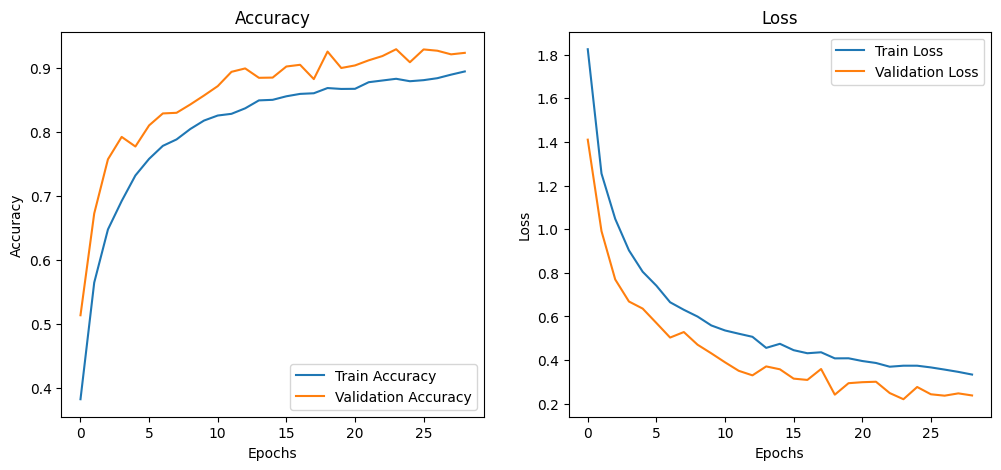

In [7]:
# Plot Akurasi dan Loss
plt.figure(figsize=(12,5))

# Plot akurasi
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [8]:
# Evaluasi pada test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 665ms/step - accuracy: 0.9290 - loss: 0.2246
Test Accuracy: 0.9370
Test Loss: 0.2111


1️. **Akurasi Test Set: 93.70%**  

> Model berhasil mengklasifikasikan **93.70% dari data test dengan benar**.  
> Ini menunjukkan bahwa model memiliki performa yang baik pada data baru yang belum pernah dilihat sebelumnya.  

2️. **Loss pada Test Set: 0.211**  

> Nilai loss yang rendah menunjukkan bahwa model tidak hanya akurat tetapi juga **stabil dalam prediksinya**.  
> Loss lebih rendah dibandingkan awal training, berarti model telah belajar dengan baik.  

3️. **Perbandingan dengan Validation Set:**  

> **Val Accuracy: 90.53% vs Test Accuracy: 93.70%** → **Tidak ada indikasi overfitting**, karena akurasi test tetap tinggi.

> **Val Loss: 0.3088 vs Test Loss: 0.211** → Model justru bekerja lebih baik di test set, yang bisa menunjukkan dataset test lebih mudah atau model cukup generalisasi dengan baik.  

# Konversi Model

- **SavedModel** adalah format standar TensorFlow yang bisa digunakan untuk deployment di server atau cloud.

- **TF-Lite** adalah format yang dioptimalkan untuk perangkat mobile dan embedded.

  
- **TFJS** adalah format untuk TensorFlow.js yang memungkinkan model dijalankan di browser dan aplikasi berbasis JavaScript.

In [11]:
import tensorflow as tf

# Load model yang sudah disimpan
model = tf.keras.models.load_model("best_model.keras")

In [22]:
# Simpan dalam format SavedModel
model.export("saved_model")

# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

# Konversi ke TensorFlow.js
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  134423350599648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134423350592784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134423351050304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134423351061920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422505476816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422505472592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422505484208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422505485264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422505484032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422505603312: TensorSpec(shape=(), dtype=tf.resource, name=None)
2025-03-19 15:10:12.2

In [24]:
# Simpan daftar kelas ke labels.txt
with open("labels.txt", "w") as f:
    for label in classes:
        f.write(label + "\n")

# Requirements

In [19]:
# Simpan daftar library Python yang digunakan beserta versinya
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [21]:
#Download semua output ke dalam file zip
!zip -r output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/model.tflite (deflated 7%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/cnn_vegetables_classification/ (stored 0%)
  adding: kaggle/working/cnn_vegetables_classification/assets/ (stored 0%)
  adding: kaggle/working/cnn_vegetables_classification/variables/ (stored 0%)
  adding: kaggle/working/cnn_vegetables_classification/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: kaggle/working/cnn_vegetables_classification/variables/variables.index (deflated 62%)
  adding: kaggle/working/cnn_vegetables_classification/fingerprint.pb (stored 0%)
  adding: kaggle/working/cnn_vegetables_classification/saved_model.pb (deflated 84%)
  adding: kaggle/working/tfjs_model/ (stored 0%)
  adding: kaggle/working/tfjs_model/group1-shard13of25.bin (deflated 6%)
  adding: kaggle/working/tfjs_model/group1-shard6of25.bin (deflated 6%)
  adding: kaggle/working/tfjs_model/group1-shard8of25.bin (deflate